In [1]:
import json
from typing import Any

with open("message_embeddings.json", "r", encoding="utf-8") as f:
    raw_data: dict[str, Any] = json.load(f)

In [2]:
from pydantic import BaseModel
from torch import Tensor
from numpy.typing import NDArray

class EmbeddedMessage(BaseModel):
    # metadata
    game_id: int
    message_idx: int
    message: str
    label: str

    # training data
    onehot_label: Tensor | NDArray[Any]
    embedding:Tensor | NDArray[Any]

    class Config:
        arbitrary_types_allowed = True

In [3]:
data: list[EmbeddedMessage] = []
for item in raw_data:
    data.append(EmbeddedMessage(
        game_id=item["game_id"],
        message_idx=item["message_idx"],
        message=item["message"],
        label=item["label"],
        onehot_label=Tensor(item["onehot_label"]),
        embedding=Tensor(item["embedding"]),
    ))

In [5]:
onehot_label_mapping = {
    "Human": Tensor([1, 0, 0]),
    "fourminds": Tensor([0, 1, 0]),
    "AllTalker": Tensor([0, 0, 1]),
}

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Human vs. Non-Human Messages

In [28]:

bow_dataset = [d.message for d in data]
bow_labels = [(d.onehot_label.unsqueeze(0)@onehot_label_mapping["Human"].unsqueeze(1)).item() for d in data]

In [18]:
bow_train, bow_test, bow_train_labels, bow_test_labels = train_test_split(
    bow_dataset, bow_labels, test_size=0.2, random_state=42
)

In [19]:
model = make_pipeline(
    CountVectorizer(
        lowercase=True,
        max_features=1000,
        ngram_range=(1, 2)
    ),
    LogisticRegression()
)
model.fit(bow_train, bow_train_labels)

,steps,"[('countvectorizer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [23]:
predictions: NDArray[Any] = model.predict(bow_test)

In [24]:
accuracy = (predictions == bow_test_labels).mean()
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 83.12%


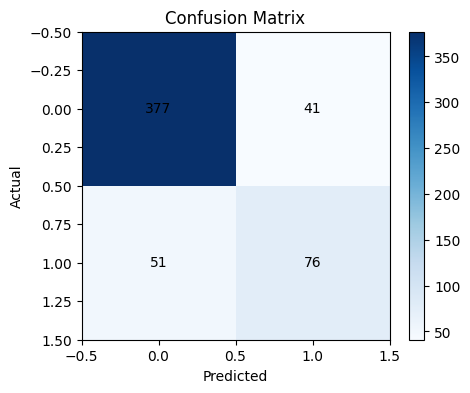

In [26]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

cm = confusion_matrix(bow_test_labels, predictions)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()